## **<center>Data Mining: Mini-Project</center>**

**This project looks at 30,000 Spotify songs to study what makes them popular and how they fit into different music genres. I use regression and classification models to predict popularity and genres. I also use clustering methods, K-Means and Hierarchical, to find patterns in the songs based on features like beat, energy, and speed. This helps us understand how songs are similar or different from each other and can help in making better music recommendations.**

**Load Dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity


# Load dataset
data = pd.read_csv('spotify_songs.csv')
data = data.groupby('playlist_genre', group_keys=False).apply(lambda x: x.sample(min(len(x), 2000)))


# Convert to lower precision data types
for col in data.select_dtypes(include=['float']).columns:
    data[col] = data[col].astype('float32')
for col in data.select_dtypes(include=['int']).columns:
    data[col] = data[col].astype('int32')

**Explore the Dataset**

In [2]:
print("First few rows of the dataset:")
print(data.head())

print("\nBasic Information:")
print(data.info())

print("\nSummary Statistics for Numerical Features:")
print(data.describe())

print("\nChecking for Missing Values:")
print(data.isnull().sum())

print("\nCategorical Feature Distribution:")
print(data.select_dtypes(include=['object']).nunique())

First few rows of the dataset:
                     track_id                               track_name  \
30311  4HaIgFi5SmByxgennUgU3Y                  Joga Esse Rabão pro Pai   
27863  5k7c38j8T7JMWqtLtKt83T                                All Night   
31372  7J9kqM3KFem6P3uSsyitIZ                         Burn Break Crash   
31111  6Omn4mz6wbBlz66hNdK3gz                 Bombaclat - Original Mix   
29185  08ty5lPyAfzcRjJcCoY5JS  When We Were Still Young - Averro Remix   

      track_artist  track_popularity          track_album_id  \
30311    Dennis DJ                54  12JvnICIz6QTIm6yfSDPiq   
27863    Habstrakt                37  3bSuLYbXGeHgyfjAlxy9uA   
31372       Aanysa                47  0CPlVPSMOTZhJSAzyn6s0b   
31111    Firebeatz                 0  2GEliEJPOCDGkXjeKeVhr1   
29185        Klaas                53  79l8Wu7Vhk8uUmJwIqHKpV   

                              track_album_name track_album_release_date  \
30311                  Joga Esse Rabão pro Pai               201

**Data Cleaning and Preprocessing**

In [3]:
print("Missing values in each column:\n", data.isnull().sum())

# Handling missing values 
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        data[col] = data[col].fillna(data[col].median())

print("\nMissing values after handling:\n", data.isnull().sum())

# 2. Remove Duplicates
initial_row_count = data.shape[0]
data.drop_duplicates(inplace=True)
print("\nRemoved", initial_row_count - data.shape[0], "duplicates")

# 3. Encode Categorical Variables
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('playlist_genre')  
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


# Standardize Numerical Features
scaler = StandardScaler()
numerical_cols = data.select_dtypes(include=['float32', 'int32']).columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

print("\nCleaned and Preprocessed Data:")
print(data.head())

Missing values in each column:
 track_id                    0
track_name                  3
track_artist                3
track_popularity            0
track_album_id              0
track_album_name            3
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

Missing values after handling:
 track_id                    0
track_name                  0
track_artist                0
track_popularity            0
track_album_id              0
track_album_name            0
track_album_release_date    0
playlist_name         

**Exploratory Data Analysis (EDA)**

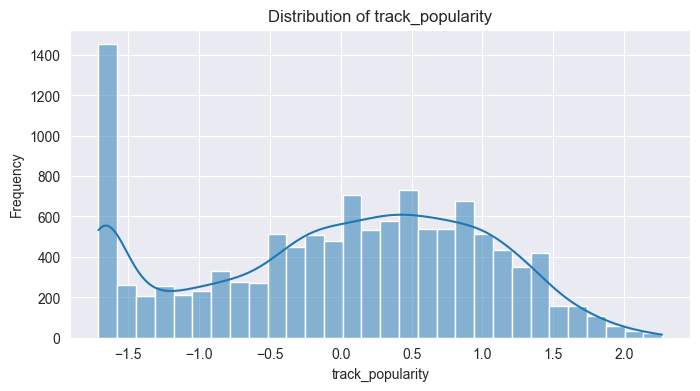

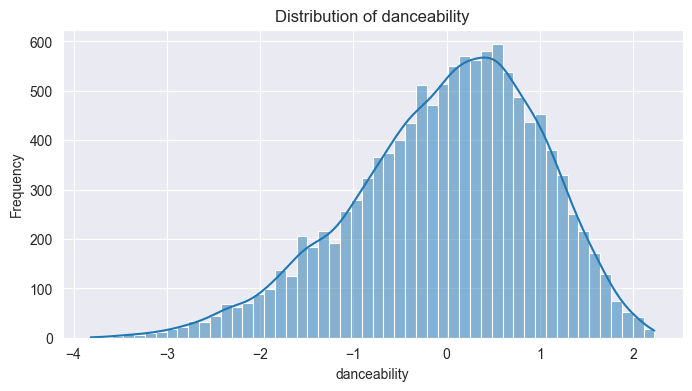

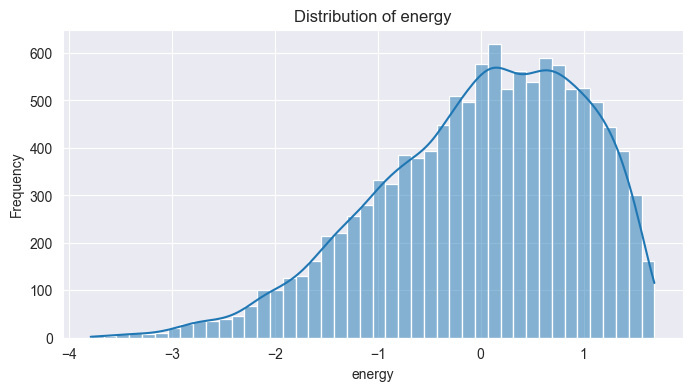

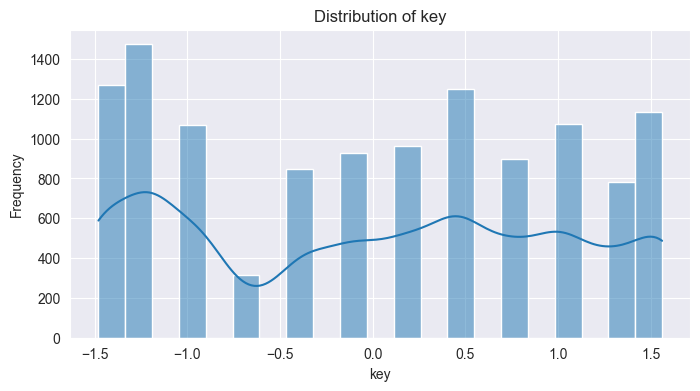

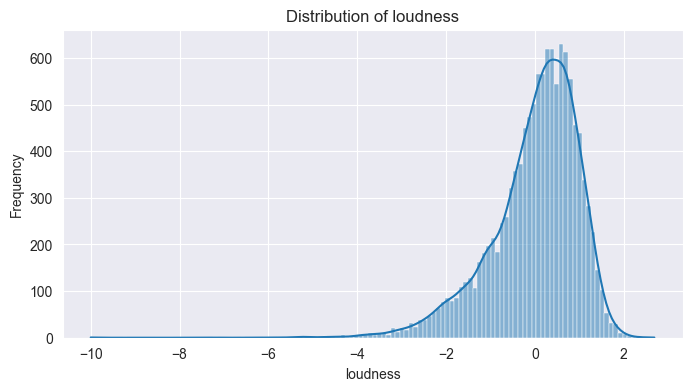

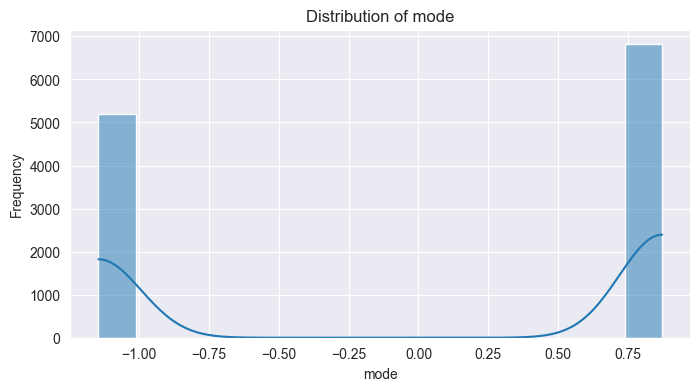

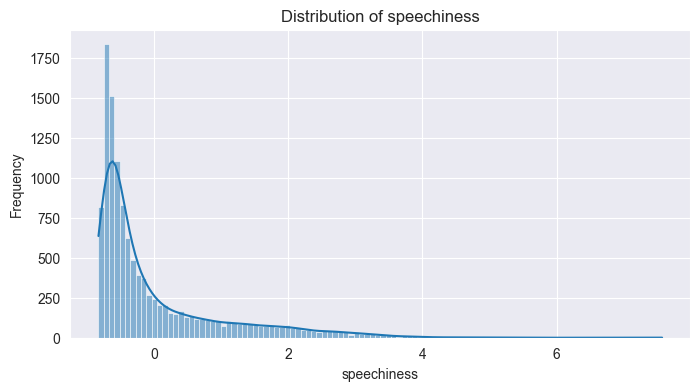

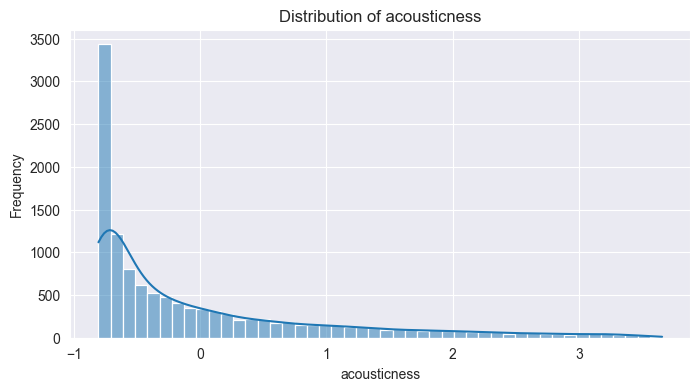

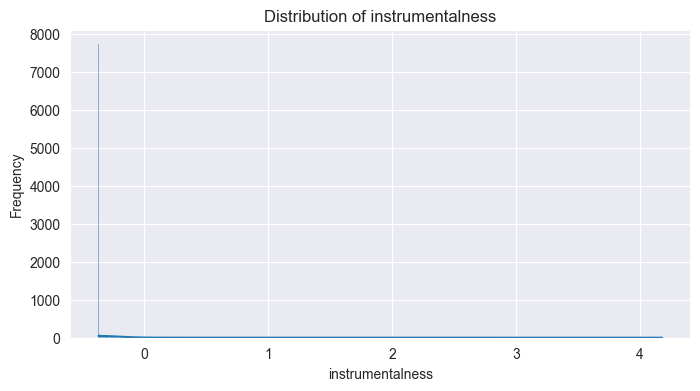

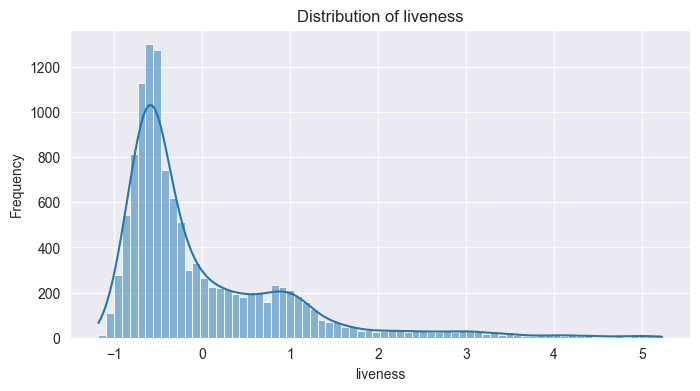

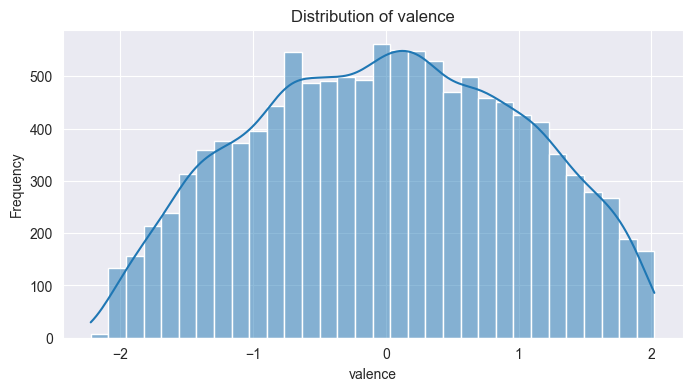

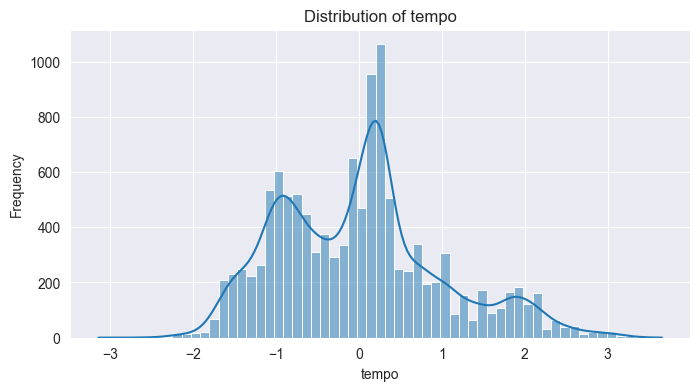

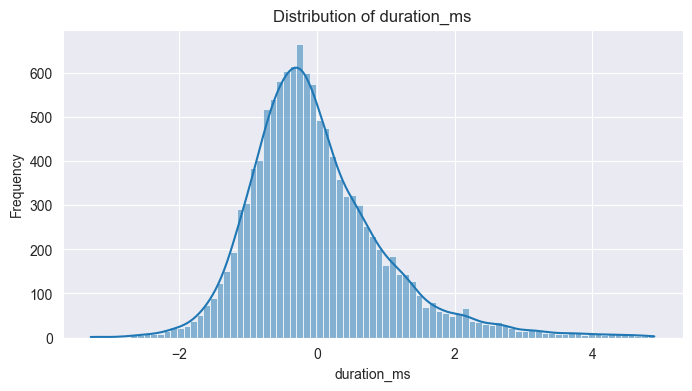

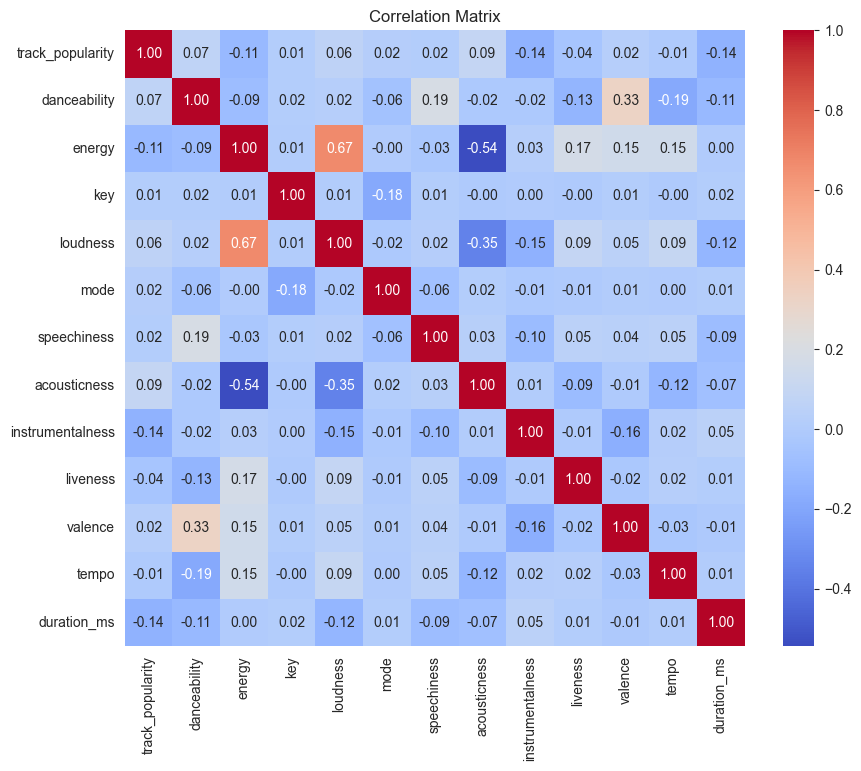

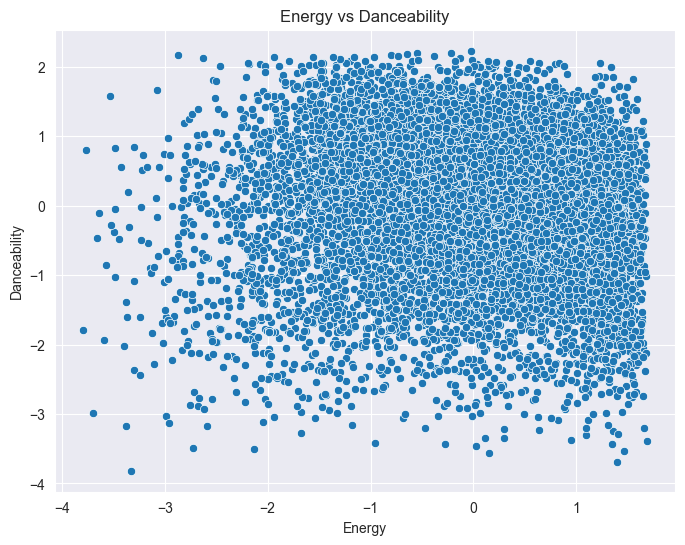

In [4]:
# Histogram for numerical features
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Explore relationships between features and target variables
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Scatter plot for a pair of features
plt.figure(figsize=(8, 6))
sns.scatterplot(x='energy', y='danceability', data=data)
plt.title('Energy vs Danceability')
plt.xlabel('Energy')
plt.ylabel('Danceability')
plt.show()

# Analyze genre distribution
if 'genre' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y='genre', data=data, order = data['genre'].value_counts().index)
    plt.title('Distribution of Genres')
    plt.xlabel('Count')
    plt.ylabel('Genre')
    plt.show()

**Feature Selection and Engineering**

In [5]:
# Feature Engineering
data['intensity'] = data['loudness'] * data['energy']

# Reducing the number of features and converting to float32
data_reduced = data.select_dtypes(include=[np.number]).astype(np.float32)

# Feature Selection
X = data_reduced.drop('track_popularity', axis=1)
y = data_reduced['track_popularity']

# Top k features using SelectKBest
selector = SelectKBest(score_func=f_regression, k=10)  
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

# Convert X_selected to DataFrame
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

print("Dataset with Selected and Engineered Features:")
print(X_selected_df.head())

Dataset with Selected and Engineered Features:
   danceability    energy  loudness      mode  acousticness  instrumentalness  \
0     -0.074165 -0.613291  0.681765 -1.146070      0.123451         -0.371337   
1      0.839891  0.318603  0.438933 -1.146070     -0.738052         -0.323249   
2      0.881127  0.257586  1.512417  0.872547     -0.493400         -0.371340   
3     -0.197872  0.185475  0.666692 -1.146070     -0.800055          1.062475   
4     -1.001967  0.362978  0.557167  0.872547     -0.670421         -0.371348   

   liveness   valence  duration_ms  intensity  
0 -0.670292 -0.335297    -1.264078  -0.418120  
1 -0.859261 -0.029303    -0.357993   0.139845  
2  0.131040 -0.507688    -0.015964   0.389577  
3 -0.657304 -1.395501     0.957994   0.123655  
4  0.721974 -0.973144    -0.898566   0.202239  


**Model Implementation & Evaluation :**

**1. Regression Model for Predicting Song Popularity**

In [6]:
# Only numeric columns
data_reduced = data.select_dtypes(include=[np.number])
X = data_reduced.drop('track_popularity', axis=1)
y = data_reduced['track_popularity']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Hyperparameters to tune
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

# Evaluate
best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Regressor with Best Params - Mean Squared Error: {mse}")
print(f"Random Forest Regressor with Best Params - Mean Absolute Error: {mae}")
print(f"Random Forest Regressor with Best Params - R-squared: {r2}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Random Forest Regressor with Best Params - Mean Squared Error: 0.8503012866016209
Random Forest Regressor with Best Params - Mean Absolute Error: 0.7529574381963331
Random Forest Regressor with Best Params - R-squared: 0.16973331304014938


**Classification Model for Genre Classification**

In [7]:
X_clf = data.drop(['playlist_genre'], axis=1)
y_clf = data['playlist_genre']

# Initialize
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 5-fold cross-validation
cv_scores_clf = cross_val_score(rf_classifier, X_clf, y_clf, cv=5)
print("Cross-validation scores for Random Forest Classifier:", cv_scores_clf)
print("Average cross-validation score:", cv_scores_clf.mean())
print("Standard deviation of cross-validation scores:", cv_scores_clf.std())

Cross-validation scores for Random Forest Classifier: [1.         0.99916667 0.99958333 0.99958333 0.99916667]
Average cross-validation score: 0.9994999999999999
Standard deviation of cross-validation scores: 0.0003118047822311749


**Clustering Model for Finding Patterns in Songs**

c:\program files\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\program files\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\program files\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\program files\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

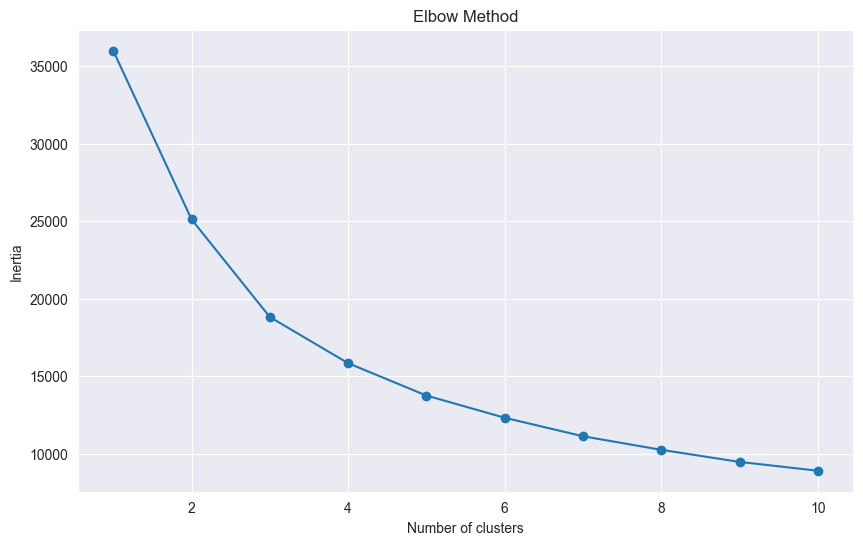

c:\program files\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.295


In [8]:
# Using a subset of features, Optimal number of clusters
clustering_features = ['danceability', 'energy', 'valence']
X_clustering = data[clustering_features]

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42)  
kmeans.fit(X_clustering)
data['cluster'] = kmeans.labels_

# Silhouette Score
from sklearn.metrics import silhouette_score
score = silhouette_score(X_clustering, kmeans.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

**Develop a Custom Algorithm**

In [10]:
# Load your dataset again
data = pd.read_csv('spotify_songs.csv')

# Select features
features = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'speechiness', 'acousticness', 'instrumentalness']
data_features = data[features]

# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_features_scaled = scaler.fit_transform(data_features)

# Get song recommendations based on similarity
def get_recommendations(song_id, data, data_features_scaled, top_n=5):
    idx = data.index[data['track_id'] == song_id][0]
    sim_scores = cosine_similarity([data_features_scaled[idx]], data_features_scaled)[0]
    sim_scores = list(enumerate(sim_scores))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    song_indices = [i[0] for i in sim_scores]
    # Return the top most similar songs
    return data['track_name'].iloc[song_indices]

# Usage
song_id = '1KWrQXjHUvVUwjTypwDD2S' 
recommendations = get_recommendations(song_id, data, data_features_scaled, top_n=5)
print("Recommended Songs:")
print(recommendations)

Recommended Songs:
30126        Damn Daniel - Radio Mix
30312       Relógio Parado (Ao Vivo)
26813    Young Ones - RudeLies Remix
30049    Young Ones - RudeLies Remix
490                            D.D.D
Name: track_name, dtype: object
